In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, to_onehot
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [4]:
caae = torch.load('caae.models')

In [5]:
aae_c = torch.load('aae_c.models')

In [11]:
def eval_model(model, criterion, loader):
    losses = []
    good_answers = 0
    
    with torch.no_grad():
        for data, target in loader:
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            losses.append(loss.item())
            good_answers += (output.argmax(dim=1) == target).sum().item()
            
    avg_loss = np.mean(losses)
    accuracy = good_answers / len(loader.dataset)
    print('Eval loss = {:.3f}, eval accuracy = {:.3f}'.format(avg_loss, accuracy))
    
    return avg_loss, accuracy

def fit_model(model, criterion, optimizer, loader, val_loader=None, epochs=1, log_interval=100, train_log=None, test_log=None):
    for epoch in range(1, epochs + 1):
        model.train()
        
        print('Epoch {}/{}'.format(epoch, epochs))
        for batch, (data, target) in enumerate(loader):
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if batch % log_interval == 0:
                print('Batch [{}/{} ({:.0f}%)] Loss: {:.3f}'.format(batch, len(loader), 100.0 * batch / len(loader), loss.item()))
        train_loss = loss.item()
        if train_log is not None:
            train_log.append(train_loss)
        
        model.eval()
        if val_loader:
            test_loss, test_acc = eval_model(model, criterion, val_loader)
            if test_log is not None:
                test_log.append(test_loss)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mnist_tanh = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    lambda x: x.to(device)
])
target_transform = lambda x: x.to(device)
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)

In [13]:
mnist_clf = FullyConnected([28 * 28, 1024, 1024, 10], activation_fn=nn.ReLU(True), flatten=True, device=device)
caae_clf = FullyConnected([10, 1024, 1024, 10], activation_fn=nn.ReLU(True), device=device)
aae_c_clf = FullyConnected([10, 1024, 1024, 10], activation_fn=nn.ReLU(True), device=device)

In [14]:
lr = 1e-3
mnist_optimizer = optim.Adam(mnist_clf.parameters(), lr)
caae_optimizer = optim.Adam(caae_clf.parameters(), lr)
aae_c_optimizer = optim.Adam(aae_c_clf.parameters(), lr)

In [15]:
mnist_train_log = []
mnist_test_log = []
fit_model(mnist_clf, nn.CrossEntropyLoss(), mnist_optimizer, 
          train_loader, valid_loader, epochs=10, train_log=mnist_train_log, test_log=mnist_test_log)

Epoch 1/10
Batch [0/200 (0%)] Loss: 2.305
Batch [100/200 (50%)] Loss: 0.251
Eval loss = 0.167, eval accuracy = 0.158
Epoch 2/10
Batch [0/200 (0%)] Loss: 0.176
Batch [100/200 (50%)] Loss: 0.105
Eval loss = 0.135, eval accuracy = 0.160
Epoch 3/10
Batch [0/200 (0%)] Loss: 0.140
Batch [100/200 (50%)] Loss: 0.090
Eval loss = 0.102, eval accuracy = 0.161
Epoch 4/10
Batch [0/200 (0%)] Loss: 0.054
Batch [100/200 (50%)] Loss: 0.072
Eval loss = 0.103, eval accuracy = 0.162
Epoch 5/10
Batch [0/200 (0%)] Loss: 0.055
Batch [100/200 (50%)] Loss: 0.060
Eval loss = 0.098, eval accuracy = 0.162
Epoch 6/10
Batch [0/200 (0%)] Loss: 0.055
Batch [100/200 (50%)] Loss: 0.052
Eval loss = 0.114, eval accuracy = 0.161
Epoch 7/10
Batch [0/200 (0%)] Loss: 0.079
Batch [100/200 (50%)] Loss: 0.033
Eval loss = 0.107, eval accuracy = 0.161
Epoch 8/10
Batch [0/200 (0%)] Loss: 0.054
Batch [100/200 (50%)] Loss: 0.065
Eval loss = 0.093, eval accuracy = 0.162
Epoch 9/10
Batch [0/200 (0%)] Loss: 0.054
Batch [100/200 (50%)] 

In [23]:
class NNLoaderTransformer:
    def __init__(self, data_loader, nn_transformer, device='cpu'):
        self.data_loader = data_loader
        self.dataset = data_loader.dataset
        self.nn_transformer = nn_transformer.to(device)
        self.device = device
    
    def __iter__(self):
        for data, target in self.data_loader:
            data, target = data.to(self.device), target.to(self.device)
            with torch.no_grad():
                latent = self.nn_transformer(data)
            yield latent, target
    
    def __len__(self):
        return len(self.data_loader)

In [26]:
caae_train_log = []
caae_test_log = []

fit_model(
    caae_clf, nn.CrossEntropyLoss(), caae_optimizer, NNLoaderTransformer(train_loader, caae['Encoder'], device),
    NNLoaderTransformer(valid_loader, caae['Encoder'], device), epochs=10, train_log=caae_train_log, test_log=caae_test_log
)

Epoch 1/10
Batch [0/200 (0%)] Loss: 2.305
Batch [100/200 (50%)] Loss: 2.303
Eval loss = 2.307, eval accuracy = 0.017
Epoch 2/10
Batch [0/200 (0%)] Loss: 2.302
Batch [100/200 (50%)] Loss: 2.309
Eval loss = 2.307, eval accuracy = 0.017
Epoch 3/10
Batch [0/200 (0%)] Loss: 2.304
Batch [100/200 (50%)] Loss: 2.304
Eval loss = 2.307, eval accuracy = 0.017
Epoch 4/10
Batch [0/200 (0%)] Loss: 2.310
Batch [100/200 (50%)] Loss: 2.304
Eval loss = 2.307, eval accuracy = 0.017
Epoch 5/10
Batch [0/200 (0%)] Loss: 2.304
Batch [100/200 (50%)] Loss: 2.304
Eval loss = 2.307, eval accuracy = 0.017
Epoch 6/10
Batch [0/200 (0%)] Loss: 2.307
Batch [100/200 (50%)] Loss: 2.305
Eval loss = 2.307, eval accuracy = 0.017
Epoch 7/10
Batch [0/200 (0%)] Loss: 2.304
Batch [100/200 (50%)] Loss: 2.307
Eval loss = 2.307, eval accuracy = 0.017
Epoch 8/10
Batch [0/200 (0%)] Loss: 2.307
Batch [100/200 (50%)] Loss: 2.304
Eval loss = 2.307, eval accuracy = 0.017
Epoch 9/10
Batch [0/200 (0%)] Loss: 2.307
Batch [100/200 (50%)] 

In [29]:
aae_c_train_log = []
aae_c_test_log = []

fit_model(
    aae_c_clf, nn.CrossEntropyLoss(), aae_c_optimizer, NNLoaderTransformer(train_loader, aae_c['Encoder'], device),
    NNLoaderTransformer(valid_loader, aae_c['Encoder'], device), epochs=10, train_log=aae_c_train_log, test_log=aae_c_test_log
)

Epoch 1/10
Batch [0/200 (0%)] Loss: 2.299
Batch [100/200 (50%)] Loss: 0.462
Eval loss = 0.421, eval accuracy = 0.142
Epoch 2/10
Batch [0/200 (0%)] Loss: 0.367
Batch [100/200 (50%)] Loss: 0.404
Eval loss = 0.380, eval accuracy = 0.144
Epoch 3/10
Batch [0/200 (0%)] Loss: 0.340
Batch [100/200 (50%)] Loss: 0.357
Eval loss = 0.354, eval accuracy = 0.146
Epoch 4/10
Batch [0/200 (0%)] Loss: 0.347
Batch [100/200 (50%)] Loss: 0.343
Eval loss = 0.350, eval accuracy = 0.146
Epoch 5/10
Batch [0/200 (0%)] Loss: 0.323
Batch [100/200 (50%)] Loss: 0.386
Eval loss = 0.335, eval accuracy = 0.148
Epoch 6/10
Batch [0/200 (0%)] Loss: 0.258
Batch [100/200 (50%)] Loss: 0.294
Eval loss = 0.321, eval accuracy = 0.148
Epoch 7/10
Batch [0/200 (0%)] Loss: 0.280
Batch [100/200 (50%)] Loss: 0.326
Eval loss = 0.320, eval accuracy = 0.148
Epoch 8/10
Batch [0/200 (0%)] Loss: 0.281
Batch [100/200 (50%)] Loss: 0.265
Eval loss = 0.321, eval accuracy = 0.149
Epoch 9/10
Batch [0/200 (0%)] Loss: 0.208
Batch [100/200 (50%)] 

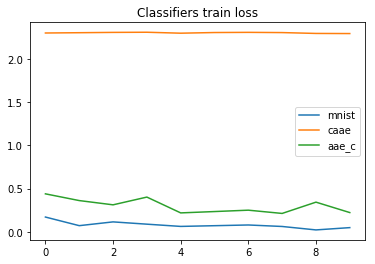

In [30]:
plt.plot(mnist_train_log, label='mnist')
plt.plot(caae_train_log, label='caae')
plt.plot(aae_c_train_log, label='aae_c')
plt.title('Classifiers train loss')
plt.legend()
plt.show()

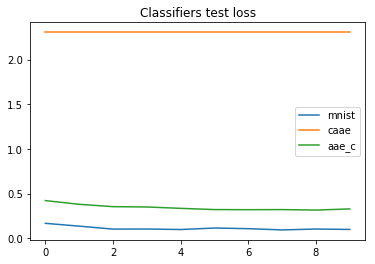

In [31]:
plt.plot(mnist_test_log, label='mnist')
plt.plot(caae_test_log, label='caae')
plt.plot(aae_c_test_log, label='aae_c')
plt.title('Classifiers test loss')
plt.legend()
plt.show()

#### Вывод: больше всего информации о классе содержится в исходных данных, в то время как в латентном слое честного автокодировщика информация о классе отсутствует (кросс-энтропия = log(10))